# 3. Train-Predict

**Result:**
- Kaggle score: 

**Tensorboard**
- Input at command: tensorboard --logdir=./log
- Input at browser: http://127.0.0.1:6006

In [1]:
import time
import os
import pandas as pd

project_name = 'Dog_Breed_Identification'
step_name = 'Train-Predict'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

cwd = os.getcwd()
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('log_path: \t' + log_path)
print('model_path: \t' + model_path)
print('output_path: \t' + output_path)

run_name: Dog_Breed_Identification_Train-Predict_20171111_230804
log_path: 	E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\log
model_path: 	E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\model
output_path: 	E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\output


In [2]:
df = pd.read_csv(os.path.join(cwd, 'input', 'labels.csv'))
print('lables amount: %d' %len(df))
df.head()

lables amount: 10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

x_train = []
y_train = {}
x_val = []
y_val = {}
x_test = []

cwd = os.getcwd()
feature_cgg16 = os.path.join(cwd, 'model', 'feature_VGG16_{}.h5'.format(20171105))
feature_cgg19 = os.path.join(cwd, 'model', 'feature_VGG19_{}.h5'.format(20171105))
feature_resnet50 = os.path.join(cwd, 'model', 'feature_ResNet50_{}.h5'.format(20171105))
feature_xception = os.path.join(cwd, 'model', 'feature_Xception_{}.h5'.format(20171105))
feature_inception = os.path.join(cwd, 'model', 'feature_InceptionV3_{}.h5'.format(20171105))
# feature_inceptionResNetV2 = os.path.join(cwd, 'model', 'feature_InceptionResNetV2_{}.h5'.format(20171028))
for filename in [feature_cgg16, feature_cgg19, feature_resnet50, feature_xception, feature_inception]:
# for filename in [feature_inception]:
    with h5py.File(filename, 'r') as h:
        x_train.append(np.array(h['train']))
        y_train = np.array(h['train_labels'])
        x_val.append(np.array(h['val']))
        y_val = np.array(h['val_labels'])
        x_test.append(np.array(h['test']))

# print(x_train[0].shape)
x_train = np.concatenate(x_train, axis=-1)
# y_train = np.concatenate(y_train, axis=0)
x_val = np.concatenate(x_val, axis=-1)
# y_val = np.concatenate(y_val, axis=0)
x_test = np.concatenate(x_test, axis=-1)
print(x_train.shape)
print(x_train.shape[1:])

print(len(y_train))
print(x_val.shape)
print(len(y_val))
print(x_test.shape)

(9710, 7168)
(7168,)
9710
(9710, 7168)
512
(10357, 7168)


In [4]:
from sklearn.utils import shuffle
(x_train, y_train) = shuffle(x_train, y_train)

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=5)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(9224, 7168)
(9224,)
(486, 7168)
(486,)


In [6]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train.shape)
print(y_val.shape)

Using TensorFlow backend.


(9224, 120)
(486, 120)


### Build CNN

In [7]:
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

In [8]:
def get_lr(x):
    lr = round(1e-4 * 0.98 ** x, 6)
    if lr < 5e-5:
        lr = 5e-5
    print(lr, end='  ')
    return lr

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\log\Dog_Breed_Identification_Train-Predict_20171111_230804


In [9]:
model = Sequential()
model.add(Dense(8196, input_shape=x_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(8196, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(8196, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))

model.compile(optimizer=Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
hist = model.fit(x_train, y_train,
                 batch_size=1024,
                 epochs=200, #Increase this when not on Kaggle kernel
                 verbose=1,  #1 for ETA, 0 for silent
                 validation_data=(x_val, y_val), 
                 callbacks=[annealer,tensorBoard])

Train on 9224 samples, validate on 486 samples
0.0001  Epoch 1/200
9224/9224 [==============================] - 3s - loss: 5.0165 - acc: 0.0081 - val_loss: 4.7593 - val_acc: 0.0062
9.8e-05  Epoch 2/200
9224/9224 [==============================] - 3s - loss: 4.8245 - acc: 0.0138 - val_loss: 4.7012 - val_acc: 0.0226
9.6e-05  Epoch 3/200
9224/9224 [==============================] - 3s - loss: 4.7552 - acc: 0.0159 - val_loss: 4.6461 - val_acc: 0.0123
9.4e-05  Epoch 4/200
9224/9224 [==============================] - 3s - loss: 4.6943 - acc: 0.0217 - val_loss: 4.5740 - val_acc: 0.0391
9.2e-05  Epoch 5/200
9224/9224 [==============================] - 3s - loss: 4.6106 - acc: 0.0334 - val_loss: 4.4513 - val_acc: 0.1008
9e-05  Epoch 6/200
9224/9224 [==============================] - 3s - loss: 4.5023 - acc: 0.0461 - val_loss: 4.3099 - val_acc: 0.0864
8.9e-05  Epoch 7/200
9224/9224 [==============================] - 3s - loss: 4.3842 - acc: 0.0540 - val_loss: 4.1556 - val_acc: 0.0905
8.7e-05  Ep

9224/9224 [==============================] - 3s - loss: 1.3926 - acc: 0.6587 - val_loss: 1.2332 - val_acc: 0.7058
5e-05  Epoch 62/200
9224/9224 [==============================] - 3s - loss: 1.3738 - acc: 0.6599 - val_loss: 1.2308 - val_acc: 0.6955
5e-05  Epoch 63/200
9224/9224 [==============================] - 3s - loss: 1.3648 - acc: 0.6512 - val_loss: 1.1950 - val_acc: 0.6975
5e-05  Epoch 64/200
9224/9224 [==============================] - 3s - loss: 1.3314 - acc: 0.6660 - val_loss: 1.1892 - val_acc: 0.7202
5e-05  Epoch 65/200
9224/9224 [==============================] - 3s - loss: 1.3114 - acc: 0.6671 - val_loss: 1.1678 - val_acc: 0.7263
5e-05  Epoch 66/200
9224/9224 [==============================] - 3s - loss: 1.2942 - acc: 0.6773 - val_loss: 1.1536 - val_acc: 0.7325
5e-05  Epoch 67/200
9224/9224 [==============================] - 3s - loss: 1.2773 - acc: 0.6751 - val_loss: 1.1282 - val_acc: 0.7387
5e-05  Epoch 68/200
9224/9224 [==============================] - 3s - loss: 1.2446

9224/9224 [==============================] - 3s - loss: 0.6210 - acc: 0.8557 - val_loss: 0.6867 - val_acc: 0.8004
5e-05  Epoch 123/200
9224/9224 [==============================] - 3s - loss: 0.6208 - acc: 0.8560 - val_loss: 0.6673 - val_acc: 0.8128
5e-05  Epoch 124/200
9224/9224 [==============================] - 3s - loss: 0.6130 - acc: 0.8570 - val_loss: 0.6746 - val_acc: 0.8066
5e-05  Epoch 125/200
9224/9224 [==============================] - 3s - loss: 0.6033 - acc: 0.8546 - val_loss: 0.6618 - val_acc: 0.8230
5e-05  Epoch 126/200
9224/9224 [==============================] - 3s - loss: 0.6056 - acc: 0.8565 - val_loss: 0.6841 - val_acc: 0.7963
5e-05  Epoch 127/200
9224/9224 [==============================] - 3s - loss: 0.5973 - acc: 0.8620 - val_loss: 0.6885 - val_acc: 0.8107
5e-05  Epoch 128/200
9224/9224 [==============================] - 3s - loss: 0.5973 - acc: 0.8631 - val_loss: 0.6489 - val_acc: 0.8251
5e-05  Epoch 129/200
9224/9224 [==============================] - 3s - loss:

9224/9224 [==============================] - 3s - loss: 0.3670 - acc: 0.9180 - val_loss: 0.5793 - val_acc: 0.8292
5e-05  Epoch 183/200
9224/9224 [==============================] - 3s - loss: 0.3664 - acc: 0.9194 - val_loss: 0.5625 - val_acc: 0.8354
5e-05  Epoch 184/200
9224/9224 [==============================] - 3s - loss: 0.3518 - acc: 0.9188 - val_loss: 0.5496 - val_acc: 0.8395
5e-05  Epoch 185/200
9224/9224 [==============================] - 3s - loss: 0.3571 - acc: 0.9175 - val_loss: 0.5773 - val_acc: 0.8230
5e-05  Epoch 186/200
9224/9224 [==============================] - 3s - loss: 0.3463 - acc: 0.9231 - val_loss: 0.5451 - val_acc: 0.8354
5e-05  Epoch 187/200
9224/9224 [==============================] - 3s - loss: 0.3460 - acc: 0.9247 - val_loss: 0.5677 - val_acc: 0.8395
5e-05  Epoch 188/200
9224/9224 [==============================] - 3s - loss: 0.3621 - acc: 0.9205 - val_loss: 0.5718 - val_acc: 0.8272
5e-05  Epoch 189/200
9224/9224 [==============================] - 3s - loss:

In [11]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

486/486 [==============================] - 0s     
Final loss: 0.5209, final accuracy: 0.8457


In [12]:
run_name_acc = run_name + '_' + str(int(final_acc*10000)).zfill(4)

In [13]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


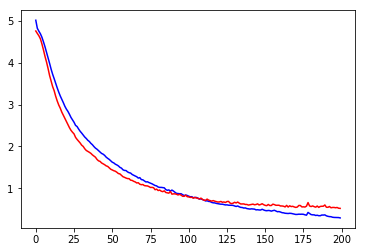

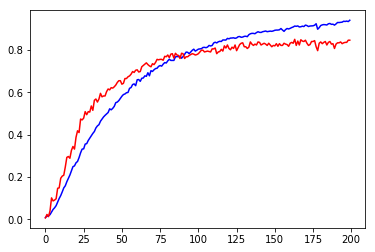

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [15]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
saveModel(model, run_name_acc)

## Predict

In [16]:
# Used to load model directly and skip train
# import os
# from keras.models import load_model
# cwd = os.getcwd()
# model = load_model(os.path.join(cwd, 'model', 'Dog_Breed_Identification_Train_20171024_155154.h5'))

In [17]:
y_pred = model.predict(x_test, batch_size=128)
print(y_pred.shape)

(10357, 120)


In [18]:
# print(y_pred[:10])
# y_pred = np.clip(y_pred, 0.005, 0.995)
# print(y_pred[:10])

In [19]:
files = os.listdir(os.path.join(cwd, 'input', 'data_test', 'test'))
print(files[:10])

['000621fb3cbb32d8935728e48679680e.jpg', '00102ee9d8eb90812350685311fe5890.jpg', '0012a730dfa437f5f3613fb75efcd4ce.jpg', '001510bc8570bbeee98c8d80c8a95ec1.jpg', '001a5f3114548acdefa3d4da05474c2e.jpg', '00225dcd3e4d2410dd53239f95c0352f.jpg', '002c2a3117c2193b4d26400ce431eebd.jpg', '002c58d413a521ae8d1a5daeb35fc803.jpg', '002f80396f1e3db687c5932d7978b196.jpg', '0036c6bcec6031be9e62a257b1c3c442.jpg']


In [20]:
cwd = os.getcwd()
df = pd.read_csv(os.path.join(cwd, 'input', 'labels.csv'))
print('lables amount: %d' %len(df))
df.head()

lables amount: 10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [21]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))
print(breed)

{'black-and-tan_coonhound', 'lakeland_terrier', 'schipperke', 'chow', 'bernese_mountain_dog', 'border_terrier', 'borzoi', 'boston_bull', 'kerry_blue_terrier', 'komondor', 'bloodhound', 'japanese_spaniel', 'saluki', 'standard_schnauzer', 'welsh_springer_spaniel', 'ibizan_hound', 'french_bulldog', 'collie', 'otterhound', 'irish_wolfhound', 'blenheim_spaniel', 'appenzeller', 'curly-coated_retriever', 'weimaraner', 'sussex_spaniel', 'siberian_husky', 'german_short-haired_pointer', 'irish_terrier', 'german_shepherd', 'wire-haired_fox_terrier', 'pomeranian', 'golden_retriever', 'shetland_sheepdog', 'scotch_terrier', 'irish_water_spaniel', 'australian_terrier', 'english_springer', 'labrador_retriever', 'staffordshire_bullterrier', 'brittany_spaniel', 'samoyed', 'rottweiler', 'norwich_terrier', 'dingo', 'mexican_hairless', 'bouvier_des_flandres', 'scottish_deerhound', 'toy_terrier', 'standard_poodle', 'old_english_sheepdog', 'bluetick', 'yorkshire_terrier', 'eskimo_dog', 'clumber', 'english_se

In [22]:
df2 = pd.read_csv('.\\input\\sample_submission.csv')
n_test = len(df2)
print(df2.shape)

(10357, 121)


In [23]:
for i in range(0, 120):
    df2.iloc[:,[i+1]] = y_pred[:,i]
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, 'pred_' + run_name_acc + '.csv')
df2.to_csv(pred_file, index=None)

In [24]:
print(run_name_acc)
print('Done !')

Dog_Breed_Identification_Train-Predict_20171111_230804_8456
Done !
